In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
alpha = 0.9
beta = 0.2
gamma = 0.1

Gamma = np.array([[1-gamma, 0, gamma], [0, 1-gamma, gamma], [beta/2, beta/2, 1-beta]])
            


Z_given_C = np.array([1-alpha, alpha, 0.5])

In [4]:
stats.bernoulli(0.5).rvs(size=[2,2])

array([[0, 1],
       [0, 0]])

In [5]:
xk = np.arange(3)
C_transitition = [
        stats.rv_discrete(values=(xk,Gamma[0,])),
        stats.rv_discrete(values=(xk,Gamma[1,])),
        stats.rv_discrete(values=(xk,Gamma[2,])),
    ]

Z_given_C[C_transitition[2].rvs(size=100)]



array([0.5, 0.1, 0.5, 0.5, 0.5, 0.5, 0.9, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.5, 0.5, 0.5,
       0.1, 0.5, 0.5, 0.9, 0.5, 0.1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.1, 0.9, 0.5, 0.5, 0.5, 0.1, 0.5, 0.1, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.5, 0.5, 0.9, 0.9, 0.5, 0.5,
       0.5, 0.5, 0.1, 0.5, 0.9, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1,
       0.5, 0.5, 0.5, 0.5, 0.1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.9, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [6]:
def sim(n=1000, T=1000, alpha = 0.9, beta = 0.2, gamma = 0.1, lamb0=1, lamb1=5):
    #xk = np.arange(3)   
    Gamma = np.array([[1-gamma, 0, gamma], 
                      [0, 1-gamma, gamma], 
                      [beta/2, beta/2, 1-beta]])
    C_transition = [
        stats.rv_discrete(values=(xk,Gamma[0,])),
        stats.rv_discrete(values=(xk,Gamma[1,])),
        stats.rv_discrete(values=(xk,Gamma[2,])),
    ]
    C = np.zeros(T, np.int64)
    C[0] = 2
    for i in range(T-1):
        C[i+1] = C_transition[C[i]].rvs()
    Z_given_C = np.array([alpha, 1-alpha, 0.5]) 
    Z = stats.bernoulli(Z_given_C[C]).rvs(size=[n,T])
    X = stats.poisson(np.where(Z, lamb1, lamb0)).rvs()
    return C,Z,X


C, Z, X = sim(10, 100)

<AxesSubplot: >

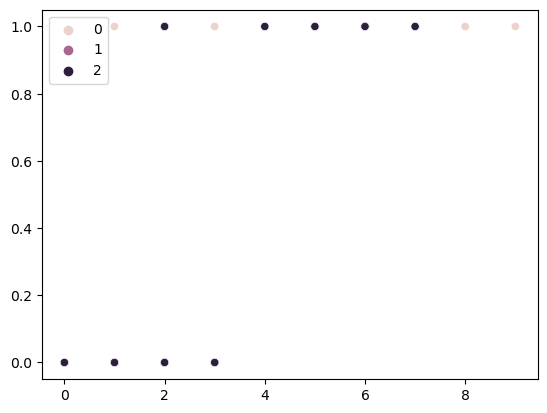

In [7]:
import seaborn as sns
sns.scatterplot(x=X[0],y=Z[0], hue=C)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


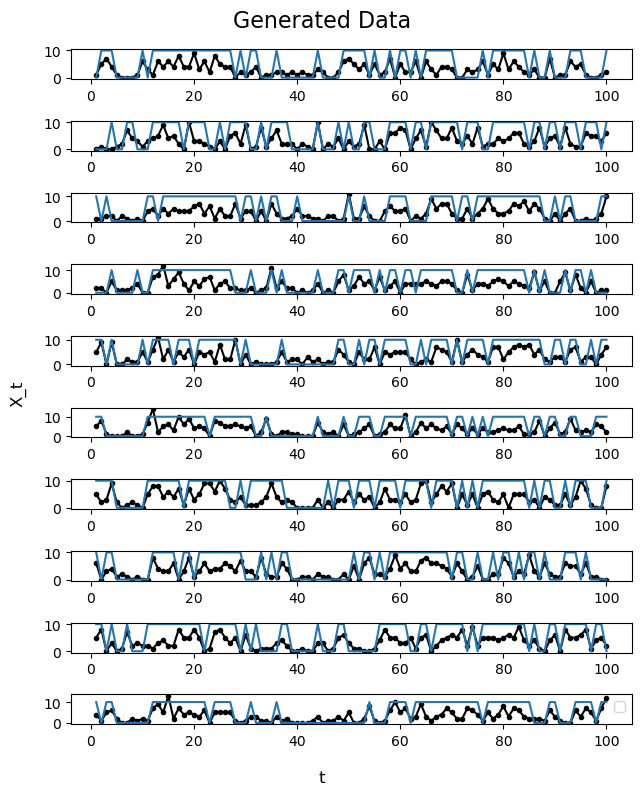

In [8]:
fig, axs = plt.subplots(10, 1, figsize= (6.5, 8))
x_plot = list(range(1,100+1))
col = ("red", "green", "blue")
color_list = [col[i] for i in C]

for i in range(10):
    y_plot = X[i]
    z_plot = Z[i]*10
    axs[i].plot(x_plot, y_plot, marker='o', markersize=3, color='black')
    axs[i].plot(x_plot, z_plot)#, c=color_list)

fig.suptitle('Generated Data', fontsize=16)
fig.supxlabel('t')
fig.supylabel('X_t')

plt.tight_layout()
plt.legend()
plt.show()

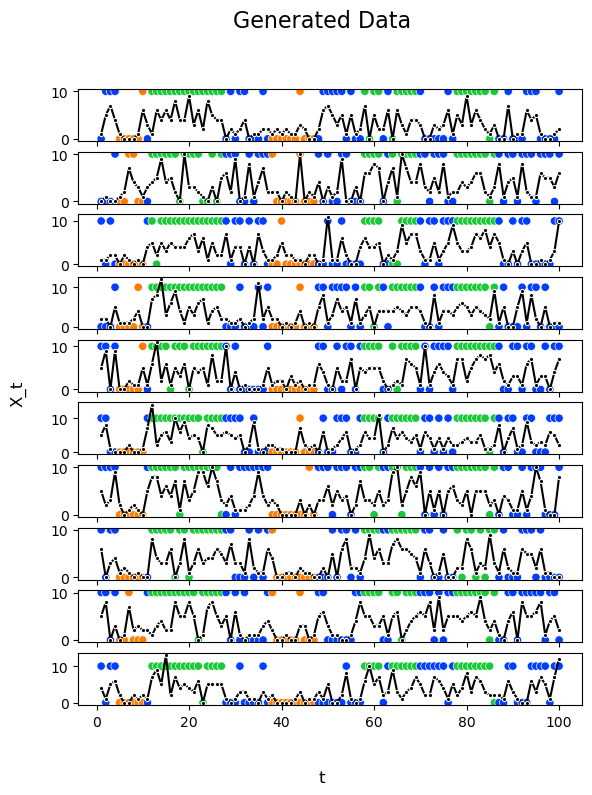

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('bright')


fig, axs = plt.subplots(10, 1, figsize=(6.5, 8))
x_plot = list(range(1, 100+1))
col = ["red", "green", "blue"]
color_list = [col[i] for i in C]

for i in range(10):
    y_plot = X[i]
    z_plot = Z[i] * 10
    sns.lineplot(x=x_plot, y=y_plot, marker='o', markersize=3, color='black', ax=axs[i], legend=False)#, label='X')
    sns.scatterplot(x=x_plot, y=z_plot, marker='o', ax=axs[i], hue=color_list, legend=False)#, label='Z')

fig.suptitle('Generated Data', fontsize=16)
fig.supxlabel('t')
fig.supylabel('X_t')

#plt.tight_layout()
plt.show()


In [73]:
C, Z, X = sim(300, 3000)

lambda0_hat = np.mean(X[Z==0])
lambda1_hat = np.mean(X[Z==1])
alpha_hat  =  np.mean(Z == C)  / np.mean(C != 2)
beta_hat    =  np.mean((C == 2) & (np.roll(C,-1) != 2)) / np.mean(C == 2)
gamma_hat   =  np.mean((C != 2) & (np.roll(C,-1) == 2)) / np.mean(C != 2)

print("""
lambda0_hat: {:.3f}, 
lambda1_hat: {:.3f}, 
alpha_hat:   {:.3f}, 
beta_hat:    {:.3f}, 
gamma_hat:   {:.3f}""".format(lambda0_hat, lambda1_hat, alpha_hat, beta_hat, gamma_hat))




lambda0_hat: 1.001, 
lambda1_hat: 4.996, 
alpha_hat:   0.100, 
beta_hat:    0.202, 
gamma_hat:   0.098


EM Algorithm

In [11]:
# Hard EM
from scipy.stats import poisson


def hard_EM_Z(X, num_steps = 200):
    Z_hat = np.random.choice([0, 1], size=X.shape, p=[0.5,0.5])
    for i in range(200):
        lambda0_hat = np.mean(X[Z_hat == 0])
        lambda1_hat = np.mean(X[Z_hat == 1])
        Z0_likelihood = np.multiply(poisson(lambda0_hat).pmf(X), np.mean(Z_hat == 0))
        Z1_likelihood = np.multiply(poisson(lambda1_hat).pmf(X), np.mean(Z_hat == 1))
        Z_hat = Z1_likelihood > Z0_likelihood
    return lambda0_hat, lambda1_hat

lambda0_hat, lambda1_hat = hard_EM_Z(X)

print("""
lambda0_hat: {:.3f}, 
lambda1_hat: {:.3f}""".format(lambda0_hat, lambda1_hat, alpha_hat))


lambda0_hat: 6.554, 
lambda1_hat: 1.574


In [12]:
def hard_EM_C(X, lambda0=1, lambda1=2, num_steps = 500):
    C_hat = np.random.choice([0, 1, 2], size=X.shape[1], p=[0.25, 0.25, 0.5])
    Z0_likelihood = poisson(lambda0).pmf(X)
    Z1_likelihood = poisson(lambda1).pmf(X)
    Z_hat = Z1_likelihood > Z0_likelihood
    XgivenZ0 = poisson(lambda0).pmf(X)
    XgivenZ1 = poisson(lambda1).pmf(X)
    C2_loglik_const = np.sum(np.log(XgivenZ0 * 0.5 + XgivenZ1 * 0.5), axis=0)
    for _ in range(num_steps):  
        alpha_hat = np.mean(Z_hat == C_hat) / np.mean(C_hat != 2)
        C0_likelihood = np.log(np.mean(C_hat == 0)) + np.sum(np.log(XgivenZ0 * alpha_hat + (1-alpha_hat) * XgivenZ1), axis=0)
        C1_likelihood = np.log(np.mean(C_hat == 1)) + np.sum(np.log(XgivenZ0 * (1-alpha_hat) + alpha_hat * XgivenZ1), axis=0)
        C2_likelihood = np.log(np.mean(C_hat == 2)) + C2_loglik_const
        C_hat = np.argmax(np.array([C0_likelihood, C1_likelihood, C2_likelihood]), axis = 0)
    return alpha_hat

hard_EM_C(X, 1, 5, 200)


/var/folders/b0/bv8482dx0cvd2732455bznb00000gn/T/ipykernel_76653/3266018481.py:10: RuntimeWarning: invalid value encountered in double_scalars
  alpha_hat = np.mean(Z_hat == C_hat) / np.mean(C_hat != 2)
/var/folders/b0/bv8482dx0cvd2732455bznb00000gn/T/ipykernel_76653/3266018481.py:11: RuntimeWarning: divide by zero encountered in log
  C0_likelihood = np.log(np.mean(C_hat == 0)) + np.sum(np.log(XgivenZ0 * alpha_hat + (1-alpha_hat) * XgivenZ1), axis=0)
/var/folders/b0/bv8482dx0cvd2732455bznb00000gn/T/ipykernel_76653/3266018481.py:12: RuntimeWarning: divide by zero encountered in log
  C1_likelihood = np.log(np.mean(C_hat == 1)) + np.sum(np.log(XgivenZ0 * (1-alpha_hat) + alpha_hat * XgivenZ1), axis=0)
/var/folders/b0/bv8482dx0cvd2732455bznb00000gn/T/ipykernel_76653/3266018481.py:13: RuntimeWarning: divide by zero encountered in log
  C2_likelihood = np.log(np.mean(C_hat == 2)) + C2_loglik_const


0.5362488888888889

Soft EM

In [28]:
def soft_EM_Z(X, num_steps = 500, lambda0_init = 1, lambda1_init = 20):
    Z0_likelihood0= poisson(lambda0_init).pmf(X)
    Z1_likelihood0 = poisson(lambda1_init).pmf(X)
    Z_hat = Z1_likelihood0 / (Z1_likelihood0 + Z0_likelihood0)
    for _ in range(num_steps):
        lambda0_hat = np.sum(X * (1-Z_hat)) / np.sum(1-Z_hat)
        lambda1_hat = np.sum(X * Z_hat) / np.sum(Z_hat)
        Z0_likelihood = poisson(lambda0_hat).pmf(X) *  np.mean(1-Z_hat)
        Z1_likelihood = poisson(lambda1_hat).pmf(X) * np.mean(Z_hat)
        Z_hat = Z1_likelihood / (Z1_likelihood + Z0_likelihood)
    return lambda0_hat, lambda1_hat, Z_hat


lambda0_hat, lambda1_hat, Z_hat = soft_EM_Z(X, 10)

lambda0_hat, lambda1_hat

(1.4317940204553294, 5.546847396006552)

In [64]:
def soft_EM_C_old(X, lambda0, lambda1, num_steps = 500):
    C_hat = np.random.uniform(0., 0.5, size=(3,X.shape[1]))
    C_hat[2] = 1-np.sum(C_hat, axis=0)
    XgivenZ0 = poisson(lambda0).pmf(X)
    XgivenZ1 = poisson(lambda1).pmf(X)
    Z_hat = np.array([XgivenZ0, XgivenZ1]) / (XgivenZ0 + XgivenZ1)
    for _ in range(num_steps):  
        alpha_hat = np.mean(Z_hat[0]*C_hat[0] + Z_hat[1]*C_hat[1]) / (1-np.mean(C_hat[2]))
        C0_likelihood = np.log(np.mean(C_hat[0])) + np.sum(np.log(XgivenZ0 * alpha_hat + (1-alpha_hat) * XgivenZ1), axis=0)
        C1_likelihood = np.log(np.mean(C_hat[1])) + np.sum(np.log(XgivenZ0 * (1-alpha_hat) + alpha_hat * XgivenZ1), axis=0)
        C2_likelihood = np.log(np.mean(C_hat[2])) + np.sum(np.log(XgivenZ0 * 0.5 + XgivenZ1 * 0.5), axis=0)
        C_log_hat = np.array([C0_likelihood, C1_likelihood, C2_likelihood])
        C_log_hat_norm = np.exp(C_log_hat - np.mean(C_log_hat))
        C_hat = C_log_hat_norm / np.sum(C_log_hat_norm, axis=0)
    return C_hat, alpha_hat

In [67]:
def soft_EM_C(X, num_steps = 500):
    C_hat = np.random.uniform(0., 0.5, size=(3,X.shape[1]))
    C_hat[2] = 1-np.sum(C_hat, axis=0)
    lambda0, lambda1, Z_hat = soft_EM_Z(X, num_steps=num_steps)
    XgivenZ0 = poisson(lambda0).pmf(X)
    XgivenZ1 = poisson(lambda1).pmf(X)
    for _ in range(num_steps):  
        alpha_hat = np.mean((1-Z_hat)*C_hat[0] + Z_hat*C_hat[1]) / (1-np.mean(C_hat[2]))
        C0_likelihood = np.log(np.mean(C_hat[0])) + np.sum(np.log(XgivenZ0 * alpha_hat + (1-alpha_hat) * XgivenZ1), axis=0)
        C1_likelihood = np.log(np.mean(C_hat[1])) + np.sum(np.log(XgivenZ0 * (1-alpha_hat) + alpha_hat * XgivenZ1), axis=0)
        C2_likelihood = np.log(np.mean(C_hat[2])) + np.sum(np.log(XgivenZ0 * 0.5 + XgivenZ1 * 0.5), axis=0)
        C_log_hat = np.array([C0_likelihood, C1_likelihood, C2_likelihood])
        C_log_hat_norm = np.exp(C_log_hat - np.mean(C_log_hat))
        C_hat = C_log_hat_norm / np.sum(C_log_hat_norm, axis=0)
    return C_hat, alpha_hat




1.2646988867050695 5.291627128452345 0.2682265555245564


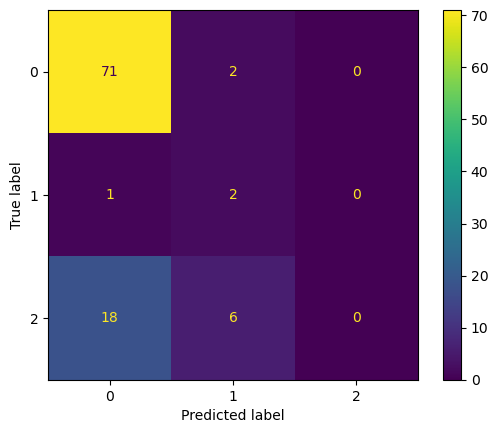

In [72]:
C, _, X = sim(8, 100)
lambda0_hat, lambda1_hat, Z_hat = soft_EM_Z(X)
C_hat, alpha_hat = soft_EM_C(X)
print(lambda0_hat, lambda1_hat, alpha_hat)

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(C, np.argmax(C_hat, axis=0))

Loading experiment 1 through 10


In [38]:
import pandas as pd

In [46]:
Ex1  = pd.read_csv("data/Ex_1.csv")
Ex2  = pd.read_csv("data/Ex_2.csv")
Ex3  = pd.read_csv("data/Ex_3.csv")
Ex4  = pd.read_csv("data/Ex_4.csv")
Ex5  = pd.read_csv("data/Ex_5.csv")
Ex6  = pd.read_csv("data/Ex_6.csv")
Ex7  = pd.read_csv("data/Ex_7.csv")
Ex8  = pd.read_csv("data/Ex_8.csv")
Ex9  = pd.read_csv("data/Ex_9.csv")
Ex10 = pd.read_csv("data/Ex_10.csv")


In [87]:
np.array(Ex1)[:,1:].T

array([[ 2,  8,  3,  4,  0,  4,  2,  6,  6,  5,  5,  9,  4,  3,  5,  1,
         0,  0,  4, 10, 10,  4,  6,  6,  5,  1,  0,  4,  9,  5,  1,  0,
         2,  4,  1,  4,  0,  2,  1,  3,  1,  5,  2,  7,  3,  3,  2,  7,
         0,  1,  5,  6,  7,  5,  6,  4,  3,  8,  2,  6,  1,  5,  5,  4,
         6,  3,  2,  1,  9,  5,  2,  3,  0,  7,  5,  7,  2, 10,  4,  5,
         4,  4,  9,  3,  0,  9,  1,  0,  1,  5,  6,  7,  5,  2, 10,  8,
         4,  6,  3,  3],
       [ 1,  6,  4,  7,  6,  5,  9,  6,  7,  6,  5,  1,  7,  4,  6,  0,
         2,  2,  3,  4,  6,  1,  0,  2,  5,  0,  8,  6,  1,  5,  6,  6,
         5,  1,  2,  4,  1,  5,  1,  1,  2,  5,  7,  1,  5,  1,  3,  6,
         6,  3,  3,  2,  8,  1,  3,  1,  2,  5,  3,  5,  2,  7,  1,  6,
         7,  5,  2,  4,  4,  2,  3,  8,  2,  2,  7,  5,  1,  1,  4,  3,
         5,  0,  2,  4,  1,  6,  4,  5,  1,  3,  3,  4,  0,  5,  1,  7,
         2,  4,  3,  2],
       [ 1,  0,  3,  0,  4,  5,  5,  3,  5,  3,  3,  5,  8,  3,  3,  1,
         3,  2